## 1. Setup and Installation

In [1]:
# Install required packages
!pip install -q transformers datasets
!pip install -q librosa soundfile audiomentations
!pip install -q praat-parselmouth pydub
!pip install -q scikit-learn matplotlib seaborn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.1/86.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.4/109.4 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 39.9 MB/s eta 0:00:00


In [2]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import warnings
warnings.filterwarnings('ignore')

# Audio processing
import librosa
import soundfile as sf
import parselmouth
from parselmouth.praat import call
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift

# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Model, Wav2Vec2Processor

# Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# Set seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


## 2. Clone Dataset from GitHub

In [3]:
# Clone repository
!git clone https://github.com/Tvenkatathanuj/SDP.git

# Set paths
HEALTHY_SPEECH_PATH = '/content/SDP/speech dataset/HC_AH/HC_AH'
PARKINSON_SPEECH_PATH = '/content/SDP/speech dataset/PD_AH/PD_AH'

print(f"Healthy speech samples: {len(os.listdir(HEALTHY_SPEECH_PATH))}")
print(f"Parkinson speech samples: {len(os.listdir(PARKINSON_SPEECH_PATH))}")

Cloning into 'SDP'...
remote: Enumerating objects: 3379, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 3379 (delta 11), reused 15 (delta 7), pack-reused 3360 (from 1)
Receiving objects: 100% (3379/3379), 255.94 MiB | 14.72 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Updating files: 100% (3352/3352), done.
Healthy speech samples: 41
Parkinson speech samples: 40


## 3. Feature Extraction Functions

In [4]:
def extract_acoustic_features(audio_path, sr=16000):
    """Extract traditional acoustic features for Parkinson's detection"""
    try:
        # Load audio
        y, sr = librosa.load(audio_path, sr=sr)

        features = {}

        # 1. MFCCs (40 coefficients)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        features['mfcc_mean'] = np.mean(mfccs, axis=1)
        features['mfcc_std'] = np.std(mfccs, axis=1)

        # 2. Chroma features (12 bins)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=12)
        features['chroma_mean'] = np.mean(chroma, axis=1)
        features['chroma_std'] = np.std(chroma, axis=1)

        # 3. Spectral features
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)

        features['spectral_centroid_mean'] = np.mean(spectral_centroid)
        features['spectral_rolloff_mean'] = np.mean(spectral_rolloff)
        features['spectral_bandwidth_mean'] = np.mean(spectral_bandwidth)

        # 4. Zero crossing rate
        zcr = librosa.feature.zero_crossing_rate(y)
        features['zcr_mean'] = np.mean(zcr)

        # 5. Jitter and Shimmer using Parselmouth
        try:
            sound = parselmouth.Sound(audio_path)
            pitch = call(sound, "To Pitch", 0.0, 75, 600)
            point_process = call(sound, "To PointProcess (periodic, cc)", 75, 600)

            jitter = call(point_process, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
            shimmer = call([sound, point_process], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)

            features['jitter'] = jitter
            features['shimmer'] = shimmer
        except:
            features['jitter'] = 0
            features['shimmer'] = 0

        # Flatten all features
        feature_vector = np.concatenate([
            features['mfcc_mean'], features['mfcc_std'],
            features['chroma_mean'], features['chroma_std'],
            [features['spectral_centroid_mean'], features['spectral_rolloff_mean'],
             features['spectral_bandwidth_mean'], features['zcr_mean'],
             features['jitter'], features['shimmer']]
        ])

        return feature_vector

    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

print("Feature extraction functions ready!")

Feature extraction functions ready!


## 4. Data Preparation

In [5]:
# Prepare dataset
data = []

for audio_file in os.listdir(HEALTHY_SPEECH_PATH):
    if audio_file.endswith('.wav'):
        data.append({
            'audio_path': os.path.join(HEALTHY_SPEECH_PATH, audio_file),
            'label': 0,  # Healthy
            'class_name': 'Healthy'
        })

for audio_file in os.listdir(PARKINSON_SPEECH_PATH):
    if audio_file.endswith('.wav'):
        data.append({
            'audio_path': os.path.join(PARKINSON_SPEECH_PATH, audio_file),
            'label': 1,  # Parkinson
            'class_name': 'Parkinson'
        })

df = pd.DataFrame(data)
print(f"Total samples: {len(df)}")
print(f"\nClass distribution:\n{df['class_name'].value_counts()}")
df.head()

Total samples: 81

Class distribution:
class_name
Healthy      41
Parkinson    40
Name: count, dtype: int64


,audio_path,label,class_name
0,/content/SDP/speech dataset/HC_AH/HC_AH/AH_322...,0,Healthy
1,/content/SDP/speech dataset/HC_AH/HC_AH/AH_904...,0,Healthy
2,/content/SDP/speech dataset/HC_AH/HC_AH/AH_378...,0,Healthy
3,/content/SDP/speech dataset/HC_AH/HC_AH/AH_777...,0,Healthy
4,/content/SDP/speech dataset/HC_AH/HC_AH/AH_511...,0,Healthy


## 5. Audio Visualization

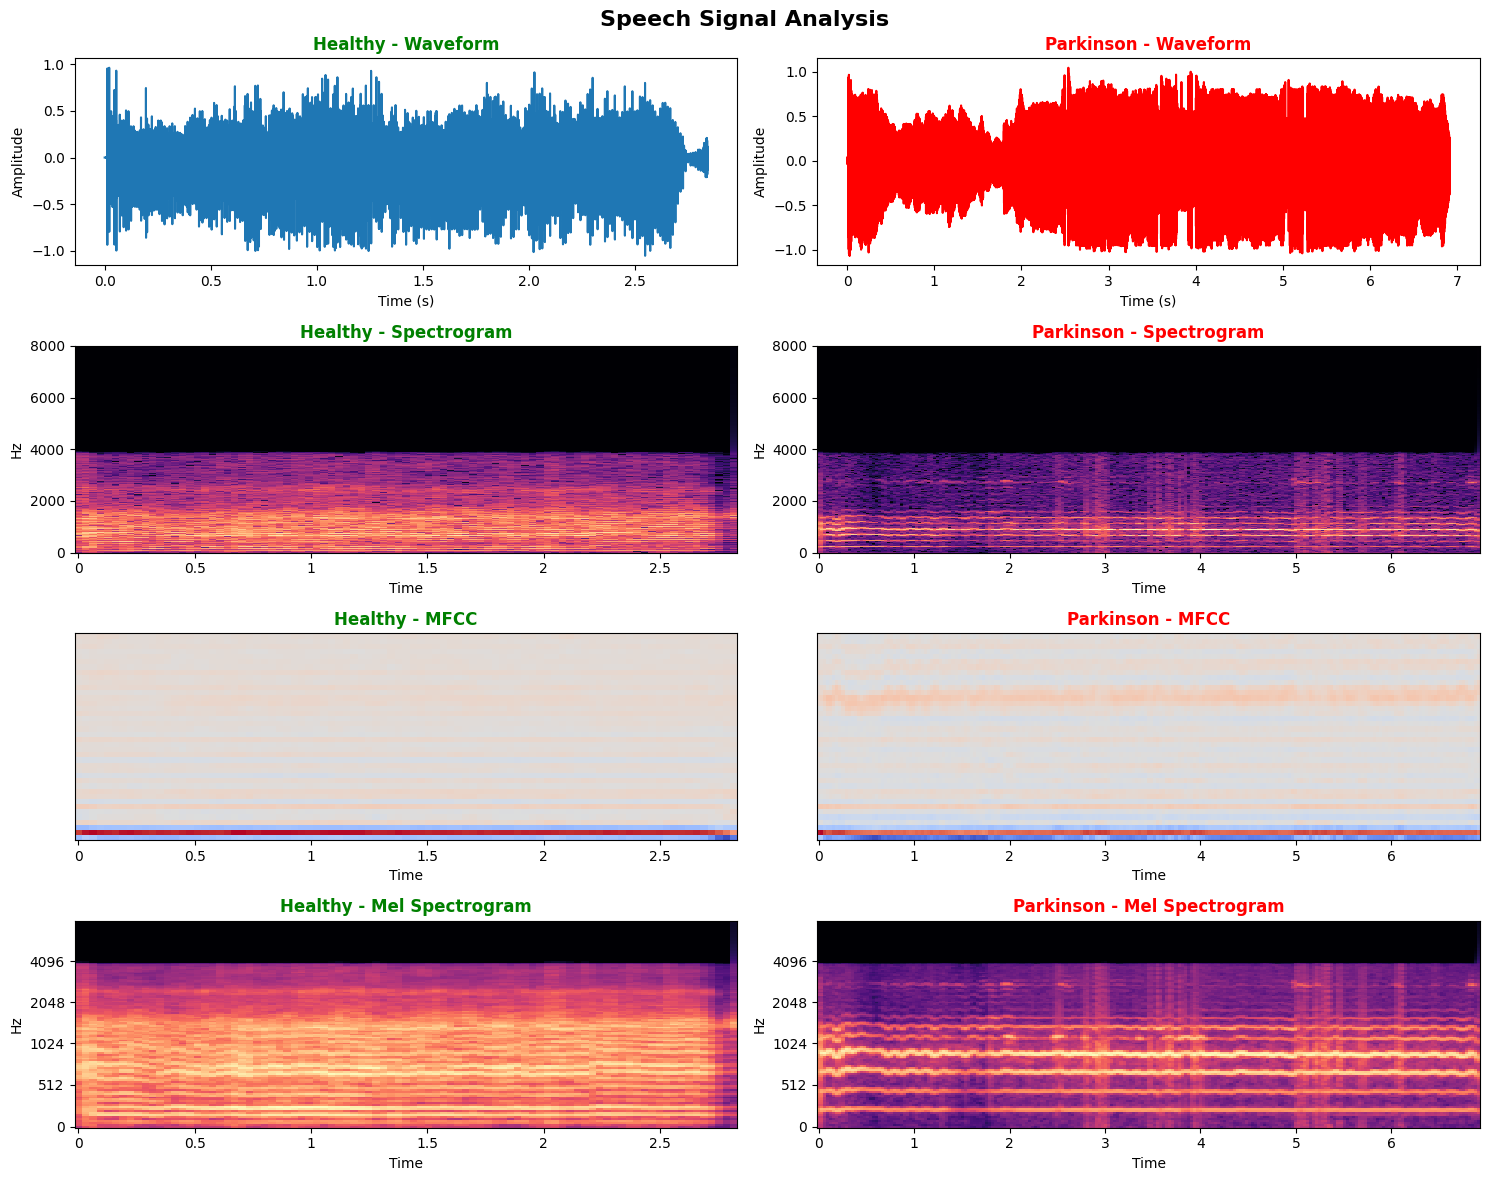

In [6]:
# Visualize sample audio files
fig, axes = plt.subplots(4, 2, figsize=(15, 12))
fig.suptitle('Speech Signal Analysis', fontsize=16, fontweight='bold')

# Healthy sample
healthy_sample = df[df['label'] == 0].sample(1).iloc[0]
y_h, sr_h = librosa.load(healthy_sample['audio_path'], sr=16000)

# Waveform
axes[0, 0].plot(np.linspace(0, len(y_h)/sr_h, len(y_h)), y_h)
axes[0, 0].set_title('Healthy - Waveform', color='green', fontweight='bold')
axes[0, 0].set_xlabel('Time (s)')
axes[0, 0].set_ylabel('Amplitude')

# Spectrogram
D_h = librosa.amplitude_to_db(np.abs(librosa.stft(y_h)), ref=np.max)
librosa.display.specshow(D_h, sr=sr_h, x_axis='time', y_axis='hz', ax=axes[1, 0])
axes[1, 0].set_title('Healthy - Spectrogram', color='green', fontweight='bold')

# MFCC
mfcc_h = librosa.feature.mfcc(y=y_h, sr=sr_h, n_mfcc=40)
librosa.display.specshow(mfcc_h, sr=sr_h, x_axis='time', ax=axes[2, 0])
axes[2, 0].set_title('Healthy - MFCC', color='green', fontweight='bold')

# Mel Spectrogram
mel_h = librosa.feature.melspectrogram(y=y_h, sr=sr_h)
mel_h_db = librosa.power_to_db(mel_h, ref=np.max)
librosa.display.specshow(mel_h_db, sr=sr_h, x_axis='time', y_axis='mel', ax=axes[3, 0])
axes[3, 0].set_title('Healthy - Mel Spectrogram', color='green', fontweight='bold')

# Parkinson sample
parkinson_sample = df[df['label'] == 1].sample(1).iloc[0]
y_p, sr_p = librosa.load(parkinson_sample['audio_path'], sr=16000)

# Waveform
axes[0, 1].plot(np.linspace(0, len(y_p)/sr_p, len(y_p)), y_p, color='red')
axes[0, 1].set_title('Parkinson - Waveform', color='red', fontweight='bold')
axes[0, 1].set_xlabel('Time (s)')
axes[0, 1].set_ylabel('Amplitude')

# Spectrogram
D_p = librosa.amplitude_to_db(np.abs(librosa.stft(y_p)), ref=np.max)
librosa.display.specshow(D_p, sr=sr_p, x_axis='time', y_axis='hz', ax=axes[1, 1])
axes[1, 1].set_title('Parkinson - Spectrogram', color='red', fontweight='bold')

# MFCC
mfcc_p = librosa.feature.mfcc(y=y_p, sr=sr_p, n_mfcc=40)
librosa.display.specshow(mfcc_p, sr=sr_p, x_axis='time', ax=axes[2, 1])
axes[2, 1].set_title('Parkinson - MFCC', color='red', fontweight='bold')

# Mel Spectrogram
mel_p = librosa.feature.melspectrogram(y=y_p, sr=sr_p)
mel_p_db = librosa.power_to_db(mel_p, ref=np.max)
librosa.display.specshow(mel_p_db, sr=sr_p, x_axis='time', y_axis='mel', ax=axes[3, 1])
axes[3, 1].set_title('Parkinson - Mel Spectrogram', color='red', fontweight='bold')

plt.tight_layout()
plt.savefig('speech_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Custom Dataset with Audio Augmentation

In [7]:
class SpeechDataset(Dataset):
    def __init__(self, dataframe, processor, max_length=16000*5, augment=False):
        self.df = dataframe.reset_index(drop=True)
        self.processor = processor
        self.max_length = max_length
        self.augment = augment

        # Audio augmentation (more aggressive for small dataset)
        if augment:
            self.augmentation = Compose([
                AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.025, p=0.7),
                TimeStretch(min_rate=0.7, max_rate=1.3, p=0.7),
                PitchShift(min_semitones=-5, max_semitones=5, p=0.7),
            ])
        else:
            self.augmentation = None

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        audio_path = self.df.iloc[idx]['audio_path']
        label = self.df.iloc[idx]['label']

        # Load audio
        y, sr = librosa.load(audio_path, sr=16000)

        # Apply augmentation
        if self.augment and self.augmentation:
            y = self.augmentation(samples=y, sample_rate=sr)

        # Pad or truncate
        if len(y) < self.max_length:
            y = np.pad(y, (0, self.max_length - len(y)), mode='constant')
        else:
            y = y[:self.max_length]

        # Process with Wav2Vec2 processor
        inputs = self.processor(y, sampling_rate=16000, return_tensors="pt", padding=True)

        # Extract acoustic features
        acoustic_features = extract_acoustic_features(audio_path)
        if acoustic_features is None:
            acoustic_features = np.zeros(110)  # Default size: 40+40+12+12+4+2=110

        return {
            'input_values': inputs.input_values.squeeze(0),
            'acoustic_features': torch.FloatTensor(acoustic_features),
            'label': torch.LongTensor([label])[0]
        }

print("Dataset class created!")

Dataset class created!


## 7. Novel Model: Wav2Vec 2.0 + BiLSTM + Multi-Head Attention

In [10]:
class MultiHeadAttention(nn.Module):
    """Multi-Head Self-Attention for temporal feature refinement"""
    def __init__(self, hidden_dim, num_heads=8, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attended, _ = self.attention(x, x, x)
        x = self.norm(x + self.dropout(attended))
        return x

class SpeechParkinsonsModel(nn.Module):
    """Hybrid Model: Wav2Vec 2.0 + BiLSTM + Multi-Head Attention + Acoustic Features"""
    def __init__(self, num_classes=2, acoustic_feature_dim=110, lstm_hidden=256, num_heads=8):
        super(SpeechParkinsonsModel, self).__init__()

        # Wav2Vec 2.0 backbone (frozen initially)
        self.wav2vec = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")
        wav2vec_dim = 768  # Wav2Vec2-base output dimension

        # Freeze Wav2Vec initially
        for param in self.wav2vec.parameters():
            param.requires_grad = False

        # Bidirectional LSTM for temporal modeling
        self.lstm = nn.LSTM(
            input_size=wav2vec_dim,
            hidden_size=lstm_hidden,
            num_layers=2,
            batch_first=True,
            dropout=0.3,
            bidirectional=True
        )

        lstm_output_dim = lstm_hidden * 2  # Bidirectional

        # Multi-Head Attention
        self.attention = MultiHeadAttention(lstm_output_dim, num_heads=num_heads)

        # Acoustic feature branch (stronger)
        self.acoustic_branch = nn.Sequential(
            nn.Linear(acoustic_feature_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
        )

        # Fusion and classification
        fusion_dim = lstm_output_dim + 128
        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

        # Feature extractor for fusion model
        self.feature_extractor = nn.Sequential(
            nn.Linear(fusion_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
        )

    def unfreeze_wav2vec(self):
        """Unfreeze Wav2Vec for fine-tuning"""
        for param in self.wav2vec.parameters():
            param.requires_grad = True

    def forward(self, input_values, acoustic_features, return_features=False):
        # Wav2Vec 2.0 encoding
        wav2vec_output = self.wav2vec(input_values).last_hidden_state

        # BiLSTM
        lstm_out, _ = self.lstm(wav2vec_output)

        # Multi-Head Attention
        attended = self.attention(lstm_out)

        # Global pooling
        pooled = torch.mean(attended, dim=1)

        # Acoustic features
        acoustic_out = self.acoustic_branch(acoustic_features)

        # Fusion
        fused = torch.cat([pooled, acoustic_out], dim=1)

        if return_features:
            # Return features for fusion model
            features = self.feature_extractor(fused)
            return features

        # Classification
        out = self.classifier(fused)

        return out

print("Speech model architecture defined!")

Speech model architecture defined!


## 8. Training Functions

In [11]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    pbar = tqdm(dataloader, desc='Training')
    for batch in pbar:
        input_values = batch['input_values'].to(device)
        acoustic_features = batch['acoustic_features'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        outputs = model(input_values, acoustic_features)
        loss = criterion(outputs, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        running_loss += loss.item()
        pbar.set_postfix({'loss': running_loss / (pbar.n + 1)})

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for batch in pbar:
            input_values = batch['input_values'].to(device)
            acoustic_features = batch['acoustic_features'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_values, acoustic_features)
            loss = criterion(outputs, labels)

            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())

            pbar.set_postfix({'loss': running_loss / (pbar.n + 1)})

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_acc, all_labels, all_preds, all_probs

print("Training functions ready!")

Training functions ready!


## 9. Data Preparation and Model Initialization

In [12]:
# Split data (with oversampling for small dataset)
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# Initialize Wav2Vec2 processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")

# Create datasets
train_dataset = SpeechDataset(train_df, processor, augment=True)
val_dataset = SpeechDataset(val_df, processor, augment=False)
test_dataset = SpeechDataset(test_df, processor, augment=False)

# Create dataloaders
BATCH_SIZE = 4  # Small due to limited data
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("DataLoaders created!")

Train: 56, Val: 12, Test: 13


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

DataLoaders created!


In [13]:
# Initialize model
model = SpeechParkinsonsModel(num_classes=2).to(device)

# Calculate class weights for imbalanced dataset
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced',
                                     classes=np.unique(train_df['label']),
                                     y=train_df['label'].values)
class_weights = torch.FloatTensor(class_weights).to(device)
print(f"Class weights: {class_weights}")

# Loss with class weighting and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-3)  # Higher LR for small dataset
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print("Ready to train!")

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Class weights: tensor([1., 1.], device='cuda:0')
Model parameters: 5,743,490
Ready to train!


## 10. Training (Two-Stage: Frozen then Fine-tuned)

In [14]:
# Stage 1: Train with frozen Wav2Vec
print("\n" + "="*60)
print("STAGE 1: Training with Frozen Wav2Vec2")
print("="*60)

NUM_EPOCHS_STAGE1 = 50  # Increased from 30
best_val_acc = 0.0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(NUM_EPOCHS_STAGE1):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS_STAGE1}")
    print("-" * 50)

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _, _ = validate_epoch(model, val_loader, criterion, device)

    scheduler.step()

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'speech_model_stage1.pth')
        print(f"✓ Model saved with val_acc: {val_acc:.4f}")

print(f"\nStage 1 Best Validation Accuracy: {best_val_acc:.4f}")


STAGE 1: Training with Frozen Wav2Vec2

Epoch 1/50
--------------------------------------------------



Validation: 100%|██████████| 3/3 [00:01<00:00,  1.98it/s, loss=0.693]


Train Loss: 0.7017, Train Acc: 0.5179
Val Loss: 0.6926, Val Acc: 0.5833
✓ Model saved with val_acc: 0.5833

Epoch 2/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s, loss=0.711]


Train Loss: 0.7501, Train Acc: 0.5000
Val Loss: 0.7110, Val Acc: 0.5000

Epoch 3/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it, loss=0.652]


Train Loss: 0.7820, Train Acc: 0.5536
Val Loss: 0.6518, Val Acc: 0.5833

Epoch 4/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s, loss=0.591]


Train Loss: 0.6983, Train Acc: 0.6429
Val Loss: 0.5906, Val Acc: 0.5000

Epoch 5/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s, loss=0.589]


Train Loss: 0.6257, Train Acc: 0.6607
Val Loss: 0.5886, Val Acc: 0.7500
✓ Model saved with val_acc: 0.7500

Epoch 6/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.96it/s, loss=0.6]


Train Loss: 0.6899, Train Acc: 0.6071
Val Loss: 0.6005, Val Acc: 0.7500

Epoch 7/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.03it/s, loss=0.633]


Train Loss: 0.7004, Train Acc: 0.5714
Val Loss: 0.6332, Val Acc: 0.7500

Epoch 8/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s, loss=0.613]


Train Loss: 0.7390, Train Acc: 0.5536
Val Loss: 0.6127, Val Acc: 0.5833

Epoch 9/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.00it/s, loss=0.619]


Train Loss: 0.7766, Train Acc: 0.5000
Val Loss: 0.6186, Val Acc: 0.6667

Epoch 10/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s, loss=0.633]


Train Loss: 0.6863, Train Acc: 0.5893
Val Loss: 0.6327, Val Acc: 0.5833

Epoch 11/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.73it/s, loss=0.611]


Train Loss: 0.6753, Train Acc: 0.6250
Val Loss: 0.6108, Val Acc: 0.5833

Epoch 12/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.67it/s, loss=0.598]


Train Loss: 0.6915, Train Acc: 0.6607
Val Loss: 0.5978, Val Acc: 0.6667

Epoch 13/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s, loss=0.578]


Train Loss: 0.6312, Train Acc: 0.6964
Val Loss: 0.5782, Val Acc: 0.6667

Epoch 14/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s, loss=0.555]


Train Loss: 0.6784, Train Acc: 0.6429
Val Loss: 0.5547, Val Acc: 0.7500

Epoch 15/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.91it/s, loss=0.58]


Train Loss: 0.6961, Train Acc: 0.5714
Val Loss: 0.5803, Val Acc: 0.6667

Epoch 16/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s, loss=0.649]


Train Loss: 0.7114, Train Acc: 0.6250
Val Loss: 0.6493, Val Acc: 0.6667

Epoch 17/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.85it/s, loss=0.647]


Train Loss: 0.6052, Train Acc: 0.6429
Val Loss: 0.6465, Val Acc: 0.5833

Epoch 18/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s, loss=0.662]


Train Loss: 0.6896, Train Acc: 0.5714
Val Loss: 0.6615, Val Acc: 0.5000

Epoch 19/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s, loss=0.676]


Train Loss: 0.6678, Train Acc: 0.6429
Val Loss: 0.6755, Val Acc: 0.5000

Epoch 20/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s, loss=0.6]


Train Loss: 0.5927, Train Acc: 0.6429
Val Loss: 0.5999, Val Acc: 0.5833

Epoch 21/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.00it/s, loss=0.575]


Train Loss: 0.5420, Train Acc: 0.7857
Val Loss: 0.5754, Val Acc: 0.5833

Epoch 22/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s, loss=0.59]


Train Loss: 0.5724, Train Acc: 0.6607
Val Loss: 0.5897, Val Acc: 0.5833

Epoch 23/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s, loss=0.63]


Train Loss: 0.6815, Train Acc: 0.6250
Val Loss: 0.6304, Val Acc: 0.5833

Epoch 24/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s, loss=0.618]


Train Loss: 0.6391, Train Acc: 0.6786
Val Loss: 0.6183, Val Acc: 0.5833

Epoch 25/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s, loss=0.63]


Train Loss: 0.5522, Train Acc: 0.6786
Val Loss: 0.6300, Val Acc: 0.5000

Epoch 26/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s, loss=0.65]


Train Loss: 0.5676, Train Acc: 0.7143
Val Loss: 0.6502, Val Acc: 0.5833

Epoch 27/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.96it/s, loss=0.67]


Train Loss: 0.5862, Train Acc: 0.6607
Val Loss: 0.6695, Val Acc: 0.5833

Epoch 28/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s, loss=0.682]


Train Loss: 0.5363, Train Acc: 0.7500
Val Loss: 0.6818, Val Acc: 0.5833

Epoch 29/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.76it/s, loss=0.674]


Train Loss: 0.6841, Train Acc: 0.6607
Val Loss: 0.6742, Val Acc: 0.5833

Epoch 30/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.52it/s, loss=0.649]


Train Loss: 0.4596, Train Acc: 0.7500
Val Loss: 0.6487, Val Acc: 0.5833

Epoch 31/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s, loss=0.602]


Train Loss: 0.6064, Train Acc: 0.6250
Val Loss: 0.6023, Val Acc: 0.5833

Epoch 32/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.03it/s, loss=0.525]


Train Loss: 0.6711, Train Acc: 0.6250
Val Loss: 0.5253, Val Acc: 0.7500

Epoch 33/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s, loss=0.499]


Train Loss: 0.5507, Train Acc: 0.7143
Val Loss: 0.4994, Val Acc: 0.8333
✓ Model saved with val_acc: 0.8333

Epoch 34/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.93it/s, loss=0.514]


Train Loss: 0.6806, Train Acc: 0.6786
Val Loss: 0.5138, Val Acc: 0.7500

Epoch 35/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s, loss=0.498]


Train Loss: 0.5941, Train Acc: 0.7679
Val Loss: 0.4979, Val Acc: 0.7500

Epoch 36/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.20it/s, loss=0.542]


Train Loss: 0.5557, Train Acc: 0.7143
Val Loss: 0.5419, Val Acc: 0.5833

Epoch 37/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s, loss=0.524]


Train Loss: 0.5541, Train Acc: 0.7321
Val Loss: 0.5235, Val Acc: 0.7500

Epoch 38/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.68it/s, loss=0.533]


Train Loss: 0.6065, Train Acc: 0.7321
Val Loss: 0.5334, Val Acc: 0.7500

Epoch 39/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.57it/s, loss=0.555]


Train Loss: 0.5370, Train Acc: 0.7679
Val Loss: 0.5547, Val Acc: 0.6667

Epoch 40/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.02it/s, loss=0.609]


Train Loss: 0.5886, Train Acc: 0.6786
Val Loss: 0.6086, Val Acc: 0.5833

Epoch 41/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s, loss=0.553]


Train Loss: 0.4774, Train Acc: 0.7143
Val Loss: 0.5531, Val Acc: 0.6667

Epoch 42/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s, loss=0.549]


Train Loss: 0.4957, Train Acc: 0.7321
Val Loss: 0.5493, Val Acc: 0.7500

Epoch 43/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s, loss=0.563]


Train Loss: 0.5454, Train Acc: 0.7857
Val Loss: 0.5628, Val Acc: 0.7500

Epoch 44/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s, loss=0.591]


Train Loss: 0.4738, Train Acc: 0.7500
Val Loss: 0.5913, Val Acc: 0.6667

Epoch 45/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s, loss=0.594]


Train Loss: 0.5510, Train Acc: 0.7143
Val Loss: 0.5945, Val Acc: 0.6667

Epoch 46/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s, loss=0.574]


Train Loss: 0.5479, Train Acc: 0.8036
Val Loss: 0.5737, Val Acc: 0.6667

Epoch 47/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s, loss=0.594]


Train Loss: 0.6869, Train Acc: 0.7321
Val Loss: 0.5942, Val Acc: 0.6667

Epoch 48/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.97it/s, loss=0.596]


Train Loss: 0.5727, Train Acc: 0.7143
Val Loss: 0.5964, Val Acc: 0.6667

Epoch 49/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s, loss=0.628]


Train Loss: 0.5242, Train Acc: 0.8036
Val Loss: 0.6275, Val Acc: 0.6667

Epoch 50/50
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.92it/s, loss=0.609]

Train Loss: 0.6118, Train Acc: 0.7679
Val Loss: 0.6092, Val Acc: 0.6667

Stage 1 Best Validation Accuracy: 0.8333


In [15]:
# Stage 2: Fine-tune entire model
print("\n" + "="*60)
print("STAGE 2: Fine-tuning Wav2Vec2")
print("="*60)

# Load best model from stage 1
model.load_state_dict(torch.load('speech_model_stage1.pth'))

# Unfreeze Wav2Vec
model.unfreeze_wav2vec()

# Lower learning rate for fine-tuning
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-6, weight_decay=1e-3)  # Much lower LR
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

NUM_EPOCHS_STAGE2 = 30  # Increased from 20
best_val_acc = 0.0

for epoch in range(NUM_EPOCHS_STAGE2):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS_STAGE2}")
    print("-" * 50)

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _, _ = validate_epoch(model, val_loader, criterion, device)

    scheduler.step()

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_speech_model.pth')
        print(f"✓ Model saved with val_acc: {val_acc:.4f}")

print(f"\nStage 2 Best Validation Accuracy: {best_val_acc:.4f}")


STAGE 2: Fine-tuning Wav2Vec2

Epoch 1/30
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s, loss=0.632]


Train Loss: 0.6398, Train Acc: 0.6964
Val Loss: 0.6325, Val Acc: 0.6667
✓ Model saved with val_acc: 0.6667

Epoch 2/30
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s, loss=0.639]


Train Loss: 0.6165, Train Acc: 0.6964
Val Loss: 0.6393, Val Acc: 0.5833

Epoch 3/30
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.97it/s, loss=0.708]


Train Loss: 0.6530, Train Acc: 0.7143
Val Loss: 0.7083, Val Acc: 0.5000

Epoch 4/30
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.50it/s, loss=0.72]


Train Loss: 0.6752, Train Acc: 0.6786
Val Loss: 0.7197, Val Acc: 0.5000

Epoch 5/30
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s, loss=0.641]


Train Loss: 0.5319, Train Acc: 0.7857
Val Loss: 0.6406, Val Acc: 0.5833

Epoch 6/30
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.50it/s, loss=0.692]


Train Loss: 0.5894, Train Acc: 0.6250
Val Loss: 0.6920, Val Acc: 0.5000

Epoch 7/30
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s, loss=0.556]


Train Loss: 0.4718, Train Acc: 0.7679
Val Loss: 0.5560, Val Acc: 0.5833

Epoch 8/30
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.96it/s, loss=0.596]


Train Loss: 0.4262, Train Acc: 0.8036
Val Loss: 0.5957, Val Acc: 0.7500
✓ Model saved with val_acc: 0.7500

Epoch 9/30
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.02it/s, loss=0.572]


Train Loss: 0.6110, Train Acc: 0.6964
Val Loss: 0.5720, Val Acc: 0.7500

Epoch 10/30
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s, loss=0.713]


Train Loss: 0.4494, Train Acc: 0.8036
Val Loss: 0.7134, Val Acc: 0.6667

Epoch 11/30
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s, loss=0.918]


Train Loss: 0.6217, Train Acc: 0.6786
Val Loss: 0.9175, Val Acc: 0.6667

Epoch 12/30
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.69it/s, loss=0.861]


Train Loss: 0.5368, Train Acc: 0.7679
Val Loss: 0.8610, Val Acc: 0.6667

Epoch 13/30
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s, loss=0.686]


Train Loss: 0.6028, Train Acc: 0.7143
Val Loss: 0.6857, Val Acc: 0.6667

Epoch 14/30
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.98it/s, loss=0.753]


Train Loss: 0.5677, Train Acc: 0.7321
Val Loss: 0.7535, Val Acc: 0.5833

Epoch 15/30
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.94it/s, loss=0.664]


Train Loss: 0.4296, Train Acc: 0.8214
Val Loss: 0.6637, Val Acc: 0.5833

Epoch 16/30
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s, loss=0.792]


Train Loss: 0.5935, Train Acc: 0.7500
Val Loss: 0.7921, Val Acc: 0.5833

Epoch 17/30
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s, loss=0.844]


Train Loss: 0.5466, Train Acc: 0.7321
Val Loss: 0.8436, Val Acc: 0.5833

Epoch 18/30
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s, loss=0.863]


Train Loss: 0.3341, Train Acc: 0.8750
Val Loss: 0.8627, Val Acc: 0.6667

Epoch 19/30
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s, loss=0.814]


Train Loss: 0.7040, Train Acc: 0.6786
Val Loss: 0.8139, Val Acc: 0.6667

Epoch 20/30
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.01it/s, loss=0.748]


Train Loss: 0.5556, Train Acc: 0.7143
Val Loss: 0.7484, Val Acc: 0.6667

Epoch 21/30
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s, loss=0.751]


Train Loss: 0.4576, Train Acc: 0.8036
Val Loss: 0.7506, Val Acc: 0.6667

Epoch 22/30
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.74it/s, loss=0.693]


Train Loss: 0.5054, Train Acc: 0.7679
Val Loss: 0.6929, Val Acc: 0.6667

Epoch 23/30
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s, loss=0.736]


Train Loss: 0.4833, Train Acc: 0.7857
Val Loss: 0.7361, Val Acc: 0.6667

Epoch 24/30
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s, loss=0.757]


Train Loss: 0.3629, Train Acc: 0.8393
Val Loss: 0.7568, Val Acc: 0.6667

Epoch 25/30
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.05it/s, loss=0.721]


Train Loss: 0.5000, Train Acc: 0.7679
Val Loss: 0.7209, Val Acc: 0.6667

Epoch 26/30
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.01it/s, loss=0.798]


Train Loss: 0.4416, Train Acc: 0.8036
Val Loss: 0.7978, Val Acc: 0.6667

Epoch 27/30
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.98it/s, loss=0.835]


Train Loss: 0.4938, Train Acc: 0.8214
Val Loss: 0.8350, Val Acc: 0.6667

Epoch 28/30
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.93it/s, loss=0.848]


Train Loss: 0.4753, Train Acc: 0.7679
Val Loss: 0.8482, Val Acc: 0.6667

Epoch 29/30
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s, loss=0.84]


Train Loss: 0.3727, Train Acc: 0.8750
Val Loss: 0.8401, Val Acc: 0.6667

Epoch 30/30
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s, loss=0.789]

Train Loss: 0.4483, Train Acc: 0.7679
Val Loss: 0.7889, Val Acc: 0.6667

Stage 2 Best Validation Accuracy: 0.7500


## 11. Evaluation

In [17]:
# Load best model
model.load_state_dict(torch.load('best_speech_model.pth'))

# Test evaluation
test_loss, test_acc, y_true, y_pred, y_probs = validate_epoch(model, test_loader, criterion, device)

print(f"\n{'='*50}")
print(f"TEST SET PERFORMANCE")
print(f"{'='*50}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Healthy', 'Parkinson'], digits=4))

# Additional metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_probs)

print(f"\nPrecision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")

Validation: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, loss=0.549]


TEST SET PERFORMANCE
Test Accuracy: 0.6923
Test Loss: 0.5493

Classification Report:
              precision    recall  f1-score   support

     Healthy     0.7143    0.7143    0.7143         7
   Parkinson     0.6667    0.6667    0.6667         6

    accuracy                         0.6923        13
   macro avg     0.6905    0.6905    0.6905        13
weighted avg     0.6923    0.6923    0.6923        13


Precision: 0.6667
Recall (Sensitivity): 0.6667
F1-Score: 0.6667
AUC-ROC: 0.7619


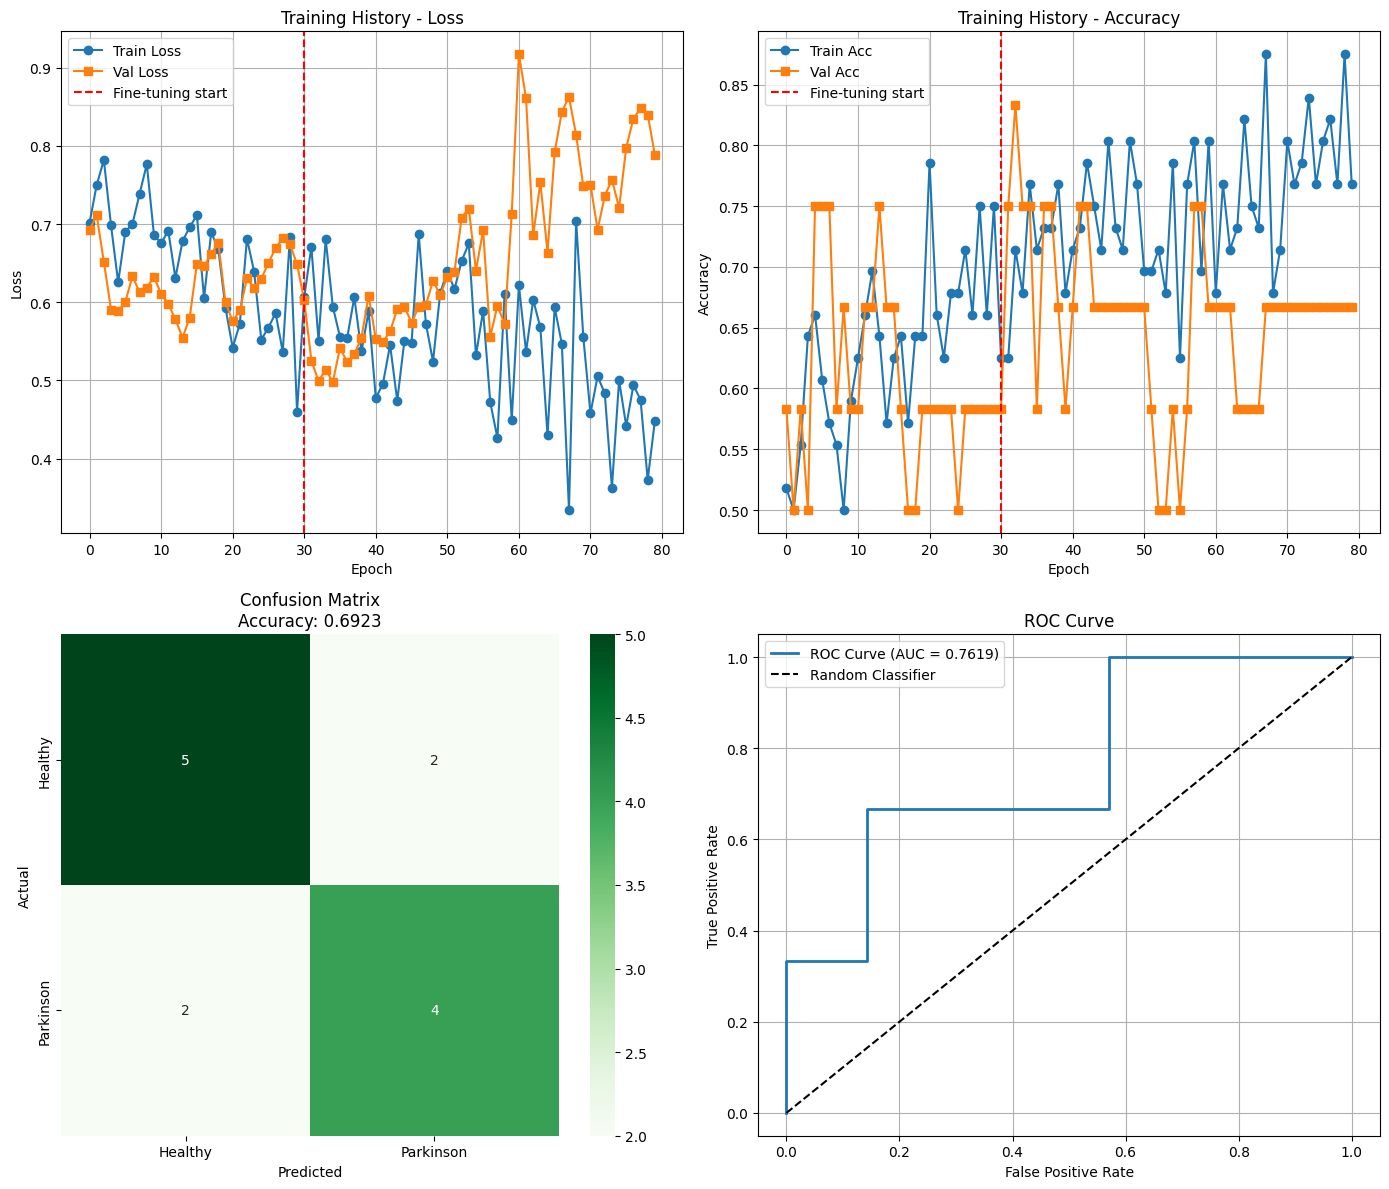

In [18]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Training history
axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0, 0].axvline(x=30, color='red', linestyle='--', label='Fine-tuning start')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training History - Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[0, 1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[0, 1].axvline(x=30, color='red', linestyle='--', label='Fine-tuning start')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Training History - Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Healthy', 'Parkinson'],
            yticklabels=['Healthy', 'Parkinson'], ax=axes[1, 0])
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')
axes[1, 0].set_title(f'Confusion Matrix\nAccuracy: {test_acc:.4f}')

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_probs)
axes[1, 1].plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})', linewidth=2)
axes[1, 1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].set_title('ROC Curve')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('speech_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

## 12. Save Model for Fusion

In [19]:
# Save final model
torch.save({
    'model_state_dict': model.state_dict(),
    'processor': processor,
    'test_acc': test_acc,
    'test_auc': auc,
}, 'speech_parkinsons_model_final.pth')

print("✓ Model saved for fusion: speech_parkinsons_model_final.pth")
print(f"\nFinal Performance:")
print(f"  Accuracy: {test_acc:.4f}")
print(f"  AUC-ROC: {auc:.4f}")
print(f"  F1-Score: {f1:.4f}")

✓ Model saved for fusion: speech_parkinsons_model_final.pth

Final Performance:
  Accuracy: 0.6923
  AUC-ROC: 0.7619
  F1-Score: 0.6667
